In [1]:
# %pip install torch
# %pip install pymoo
# %pip install pywin32

In [2]:
import os, sys

# Get the absolute path of the notebook's directory
notebook_dir = os.getcwd()

# Navigate to the parent directory
parent_dir = os.path.abspath(os.path.join(notebook_dir, ".."))

# Add the parent directory to sys.path so we can import modules
sys.path.append(parent_dir)

# Verify the path
print(f"Added to sys.path: {parent_dir}")

# Add it to sys.path
sys.path.append(parent_dir)

print(parent_dir)
from localityaware.module import *
from NSGA_nn.nsga import *
from Vinyl_Distillation.VCDistillation import *

Added to sys.path: C:\Users\conno\OneDrive\Desktop\Aspen\Aspen
C:\Users\conno\OneDrive\Desktop\Aspen\Aspen
['C:\\Program Files\\WindowsApps\\PythonSoftwareFoundation.Python.3.13_3.13.1008.0_x64__qbz5n2kfra8p0\\python313.zip', 'C:\\Program Files\\WindowsApps\\PythonSoftwareFoundation.Python.3.13_3.13.1008.0_x64__qbz5n2kfra8p0\\DLLs', 'C:\\Program Files\\WindowsApps\\PythonSoftwareFoundation.Python.3.13_3.13.1008.0_x64__qbz5n2kfra8p0\\Lib', 'C:\\Program Files\\WindowsApps\\PythonSoftwareFoundation.Python.3.13_3.13.1008.0_x64__qbz5n2kfra8p0', '', 'C:\\Users\\conno\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python313\\site-packages', 'C:\\Users\\conno\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python313\\site-packages\\win32', 'C:\\Users\\conno\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python313\\sit

In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import pickle
import os
import time

# Define the file path for saving/loading the data
data_file = "vcdistil.pkl"



print("Generating new data...")
assSim = VCDistillation(AspenFile="Vinyl Chloride Distillation.bkp", 
                        wdpath="../Vinyl_Distillation", 
                        visibility=True)

Generating new data...
The current Directory is :  
C:\Users\conno\OneDrive\Desktop\Aspen\Aspen\Vinyl_Distillation
The new Directory where you should also have your Aspen file is : 
C:\Users\conno\OneDrive\Desktop\Aspen\Aspen\Vinyl_Distillation
Aspen is active now. If you dont want to see aspen open again take VISIBITLY as False 



In [4]:
import numpy as np
import time
from scipy.stats import qmc

# Number of samples you want to generate
N = 60  # change this as needed
seed = 42

# Define lower and upper bounds for the 8 parameters
lower_bounds = np.array([
    30,    # trays low
    2,     # feed position low
    0.1,   # reflux ratio low
    0.46,  # distillate-to-feed ratio low
    35,    # trays high
    2,     # feed position high
    0.1,   # reflux ratio high
    0.89   # distillate-to-feed ratio high
])

upper_bounds = np.array([
    36,    # trays low
    29,    # feed position low
    1.5,   # reflux ratio low
    0.48,  # distillate-to-feed ratio low
    42,    # trays high
    34,    # feed position high
    1.5,   # reflux ratio high
    0.91   # distillate-to-feed ratio high
])


# Initialize the Latin Hypercube sampler for 8 dimensions
sampler = qmc.LatinHypercube(d=8, seed =42)
sample_unit = sampler.random(n=N)  # Samples in [0, 1) with shape (N,8)

# Scale the samples to the desired parameter ranges
samples = qmc.scale(sample_unit, lower_bounds, upper_bounds)

# print("samples_scaled", samples_scaled)

# For integer parameters, round the values.
# We assume indices 0, 1, 4, and 5 are integers.
samples[:, 0] = np.round(samples[:, 0]).astype(int)
samples[:, 1] = np.round(samples[:, 1]).astype(int)
samples[:, 4] = np.round(samples[:, 4]).astype(int)
samples[:, 5] = np.round(samples[:, 5]).astype(int)

# For debugging: print the first few samples
print("First 5 LHS samples (each row corresponds to [trays low, feed low, reflux low, dist-feed low, trays high, feed high, reflux high, dist-feed high]):")
print(samples[:5])

First 5 LHS samples (each row corresponds to [trays low, feed low, reflux low, dist-feed low, trays high, feed high, reflux high, dist-feed high]):
[[35.         13.          1.43329938  0.46543421 40.         18.
   0.96890674  0.90273798]
 [31.          3.          0.79134805  0.47635775 36.         32.
   0.76632034  0.89725759]
 [32.         11.          1.08402194  0.46312278 37.          3.
   0.45068371  0.89603563]
 [33.         21.          1.16244318  0.46165207 42.         29.
   1.13262222  0.8946775 ]
 [34.          3.          0.69571036  0.46793684 40.         15.
   0.63137212  0.8974434 ]]


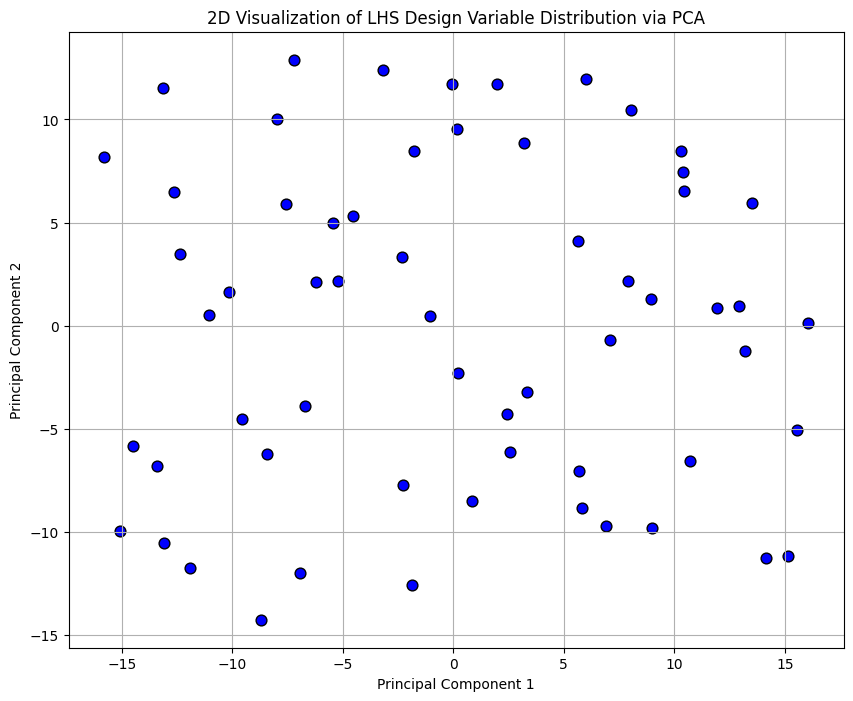

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Here, we assume samples_scaled is a NumPy array with shape (N, 8)
# representing your 8 design variables from LHS.
X_params = samples[:, :8]

# Apply PCA to reduce the 8-dimensional parameter space to 2 dimensions.
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X_params)

# Create a scatter plot for the reduced parameters.
plt.figure(figsize=(10, 8))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], color='blue', edgecolor='k', s=60)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('2D Visualization of LHS Design Variable Distribution via PCA')
plt.grid(True)
plt.show()


In [7]:
# 2) pack the single test case into the expected x‑dict
x = {
    "RadFrac": {
        "RADFRAC1": [34, [19, "FEED"], 1.0492, 0.465],
        "RADFRAC2": [40, [17, "B1"],   1.0701, 0.902],
    }
}

# 3) run it
results = assSim.runSim(x)

RADFRAC1:
  CS1 stage range: 2 → 18
  CS2 stage range: 19 → 33
RADFRAC2:
  CS1 stage range: 2 → 16
  CS2 stage range: 17 → 39


In [8]:
# Start timing the data generation (simulation evaluations)
            # first, import the module normally

start_time = time.time()

data_sim = []
start = 14

print("Total samples:", len(samples))
for idx, param_array in enumerate(samples):
    print("Input for", idx +  1)
    # Convert the 8 parameters into the expected input format
    x_unflat = assSim.unflatten_params(param_array)
    # Run the objective function (this is where the Aspen or dummy simulation is called)
    
    results = assSim.runSim(x_unflat)
    print("Results for", idx + 1)
    print(results)
    output = assSim.costFunc(results)
    data_sim.append(list(param_array) + list(output))
    assSim.reset()
print(data_sim[:2])
data_sim = np.array(data_sim)
elapsed = time.time() - start_time


Total samples: 60
Input for 1
RADFRAC1:
  CS1 stage range: 2 → 12
  CS2 stage range: 13 → 34
RADFRAC2:
  CS1 stage range: 2 → 17
  CS2 stage range: 18 → 39
Results for 1
{'COL_1_DIAM': 0.9385028954500001, 'COL_2_DIAM': 0.8794814048, 'COL_1_HEIGHT': 24.14016, 'COL_2_HEIGHT': 27.79776, 'COL_1_HEAT_UTIL': 19.7117941, 'COL_2_HEAT_UTIL': 19.7117941, 'COL_1_COOL_UTIL': 74.2966803, 'COL_2_COOL_UTIL': 13.0999706, 'COL_1_REBOILER_DUTY': 1679.5523616100002, 'COL_2_REBOILER_DUTY': 1204.49149822, 'ACETYLENE_PURITY': 2.63847746e-24, 'VC_PURITY': 1.0}
🔄 Aspen simulation successfully reinitialized.
Input for 2
RADFRAC1:
  CS1 stage range: 2 → 2
  CS2 stage range: 3 → 30
RADFRAC2:
  CS1 stage range: 2 → 31
  CS2 stage range: 32 → 35
Results for 2
{'COL_1_DIAM': 0.7593024474500001, 'COL_2_DIAM': 0.81734911425, 'COL_1_HEIGHT': 21.21408, 'COL_2_HEIGHT': 24.87168, 'COL_1_HEAT_UTIL': 14.6344303, 'COL_2_HEAT_UTIL': 14.6344303, 'COL_1_COOL_UTIL': 56.2247512, 'COL_2_COOL_UTIL': 11.4413172, 'COL_1_REBOILER_DUT

com_error: (-2147023170, 'The remote procedure call failed.', None, None)

In [ ]:

print(f"Generated {len(data_sim)} simulation points in {elapsed:.2f} seconds.")


import pickle
with open("../NSGA_nn/results/vinyl/data_sim_12dim.pkl", "wb") as f:
    pickle.dump({"data": data_sim, "time_sec": elapsed}, f)

data_sim = np.array(data_sim)
data_gen_time = time.time() - start_time  # Total time to generate data
total_original_assSim_calls = len(data_sim)

In [ ]:
import pickle
with open('../NSGA_nn/results/vinyl/data_sim_12dim.pkl', 'rb') as f:
    out = pickle.load(f)
data_sim = out['data']

In [ ]:
print(data_sim[0])
print(len(data_sim[0]))

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# For demonstration purposes, assume you have an array of objectives
# with shape (N, 2) where each row is [TAC, CO₂ Emissions].
# Replace this with your actual data.
objectives = data_sim[:, -2:]  # Assuming the last two columns are the objectives
plt.figure(figsize=(10, 8))
plt.scatter(objectives[:, 0], objectives[:, 1], color='blue', marker='o', label="Solutions")
plt.xlabel('Total Annual Cost (TAC)')
plt.ylabel('CO₂ Emissions')
plt.title('Pareto Plot: TAC vs CO₂ Emissions')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
print(len(data_sim))

# Instantiate the scaler with your provided ranges for 8-D inputs and 2-D outputs.
scaler = TorchMinMaxScaler(
    feature_range=(-1, 1), 
    max_vals=[36, 29, 1.5, 0.48, 42, 34, 1.5, 0.91],  # maximum for each of the 8 input parameters
    min_vals=[30, 2, 0.1, 0.46, 35, 2, 0.1, 0.89],       # minimum for each of the 8 inputs
    scale_y=True,
    min_y=[0, 0, 1e5, 1e4],   # minimum for the 4 outputs (e.g., acetyl purity, vinyl purity, TAC and CO₂)
    max_y=[1, 1, 1e6, 6e5]    # maximum for the 4 outputs
)

# Correct: use data_sim[:, :8] for inputs, and data_sim[:, 8:] for outputs.
data_sim_xscaled, data_sim_yscaled = scaler.transform(data_sim[:, :8], data_sim[:, 8:])

# Convert the PyTorch tensors to NumPy arrays.
data_sim_xscaled = data_sim_xscaled.detach().cpu().numpy()
data_sim_yscaled = data_sim_yscaled.detach().cpu().numpy()

# Check shapes for debugging:
print("Shape of scaled inputs:", data_sim_xscaled.shape)   # should be (N, 8)
print("Shape of scaled outputs:", data_sim_yscaled.shape)    # should be (N, 2)

# Recombine scaled inputs and outputs into one array with 10 columns (8 + 2).
data_sim_scaled = np.column_stack([data_sim_xscaled, data_sim_yscaled])
print("Shape of combined scaled data:", data_sim_scaled.shape)
print("First few rows of combined scaled data:\n", data_sim_scaled[:5])


# **Initialize Model & Dataset**
dataset = DynamicDataset(data_sim_scaled, num_inputs=8)
model = MLP(8, [50, 50, 20, 20, 50, 50], 4)

print("Dataset and model initialized.")

In [ ]:
from VCDistillation import VinylDistillationNNProblem
threshold_scaler = TorchMinMaxScaler(
    feature_range=(-1, 1),
    min_vals=[0,0],  # Input bounds for 8 variables
    max_vals=[1,1],
    scale_y=False
)
problem = VinylDistillationNNProblem(model,threshold_scaler)

In [ ]:
out = optimize_surr_nsga(model=model,
                   dataset=dataset,
                   assSim=assSim,
                   problem=problem,
                   lrs={'first':1e-4, 'others':1e-4},
                   epochs={'first':3000, 'others':300},
                   min_vals=scaler.min_x,
                   max_vals=scaler.max_x,
                   scaler=scaler,
                   device='cpu',
                   iter=5,
                   print_loss=True,
                   print_it_data=True,
                   pop_size=1000,
                   n_gen = 10,
                   new_data_size=10,
                   batch_size=128
                   )

In [ ]:
import os
import datetime
import pickle

data_gen_time = 0
total_original_assSim_calls = 100

print(os.getcwd())
# Get current notebook name manually (or hardcode it here)
notebook_name = "vinyl"  # or os.path.basename(__file__).replace(".py", "")

# Get timestamp
now = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

# Construct path: results/<notebook_name>/run_<timestamp>/
base_dir = os.path.join("../NSGA_nn/results", notebook_name)
save_dir = os.path.join(base_dir, f"run_{now}")
os.makedirs(save_dir, exist_ok=True)
print(save_dir)

print(f"Results will be saved in: {save_dir}")

# Save out.pkl
out["data_gen_time"] = data_gen_time
out["total_original_assSim_calls"] = total_original_assSim_calls
with open(os.path.join(save_dir, "out.pkl"), "wb") as f:
    pickle.dump(out, f)

# Save scaler
with open(os.path.join(save_dir, "scaler.pkl"), "wb") as f:
    pickle.dump(scaler, f)

# Save dataset
with open(os.path.join(save_dir, "dataset.pkl"), "wb") as f:
    pickle.dump(dataset, f)

print(f"Saved all results in {save_dir}")
